# RSNA STR Pulmonary Embolism Detection

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [9]:
# Read in the file
df = pd.read_csv('train (1).csv')

In [10]:
print(df.shape)
df.head()

(1790594, 17)


,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


Each Study Instance ID and Series Instance ID is unique to one participant. We have 7,279 participants in the dataset with 1.79 million images in total - roughly 233 images per participant.

In [131]:
print(df.StudyInstanceUID.nunique())
print(df.SeriesInstanceUID.nunique())
print(df.SOPInstanceUID.nunique())

7279
7279
1790594


In [119]:
df.isna().sum()

StudyInstanceUID              0
SeriesInstanceUID             0
SOPInstanceUID                0
pe_present_on_image           0
negative_exam_for_pe          0
qa_motion                     0
qa_contrast                   0
flow_artifact                 0
rv_lv_ratio_gte_1             0
rv_lv_ratio_lt_1              0
leftsided_pe                  0
chronic_pe                    0
true_filling_defect_not_pe    0
rightsided_pe                 0
acute_and_chronic_pe          0
central_pe                    0
indeterminate                 0
dtype: int64

In [11]:

df.iloc[:, 3:].mean()

pe_present_on_image           0.053915
negative_exam_for_pe          0.676393
qa_motion                     0.008251
qa_contrast                   0.015797
flow_artifact                 0.040159
rv_lv_ratio_gte_1             0.128750
rv_lv_ratio_lt_1              0.174372
leftsided_pe                  0.210899
chronic_pe                    0.040140
true_filling_defect_not_pe    0.008037
rightsided_pe                 0.257565
acute_and_chronic_pe          0.019458
central_pe                    0.054469
indeterminate                 0.020485
dtype: float64

In [123]:
# Creating a function that takes an x and y value and plots the respective information in a specific format
# consistent with our presentation theme.

def make_bar(x, y, title, y_label):
    fig, ax = plt.subplots(figsize=(10,6))    
    color = ['#2a3990','#D23369', '#f06292']
    ax.bar(x,y, color = color)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_yticks(np.arange(0,1.2,.2))

    spine_position = ['top', 'left', 'right']
    for spine in spine_position:    
        ax.spines[spine].set_color('white')

    for a,b in zip(x,y):

        label = "{:.2f}".format(b)

        plt.annotate(label, # this is the text
                     (a,b), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.show()

### Class Balance
A large majority (95 percent) of the roughly 1.75 million images in our dataset did not have a PE present on the image. The five percent (96,540) that did belonged to 2,368 individuals.

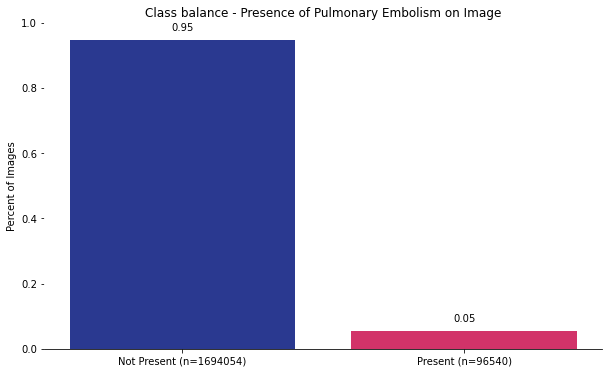

In [126]:
y = df.pe_present_on_image.value_counts()/df.pe_present_on_image.value_counts().sum()
feature_names = ['Not Present', 'Present']
x = []
for i in range(len(feature_names)):
    x.append('%s (n=%s)'%(feature_names[i], str(df.pe_present_on_image.value_counts()[i])))

make_bar(x,y,
        title = 'Class balance - Presence of Pulmonary Embolism on Image',
        y_label = 'Percent of Images')


### PE Presence Among Participants
Among the 7,279 participants in our sample, only one third (2,368) tested positive for PE. Those who tested positive for PE had at least one image in their file that presented PE. Those with no images presenting PE tested negative. 

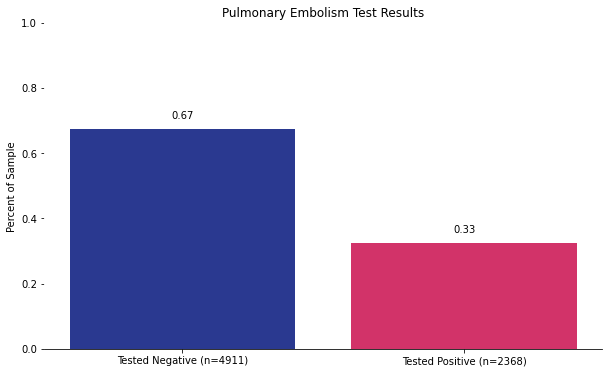

In [125]:
neg_val_counts = df.groupby('StudyInstanceUID').negative_exam_for_pe.median().value_counts()
n_values = neg_val_counts.reset_index()
y = neg_val_counts/df.StudyInstanceUID.nunique()
feature_names = ['Tested Negative', 'Tested Positive']
x = []
for i in range(len(feature_names)):
    x.append('%s (n=%s)'%(feature_names[i], str(n_values.negative_exam_for_pe[i])))
make_bar(x,y,
        title='Pulmonary Embolism Test Results',
        y_label='Percent of Sample')

### Pulmonary Embolism Locaiton
Of images that presented PE (96,540), the right and left ventricles were the most common locations of the PE. Most participants also had multiple PE present in their lungs.

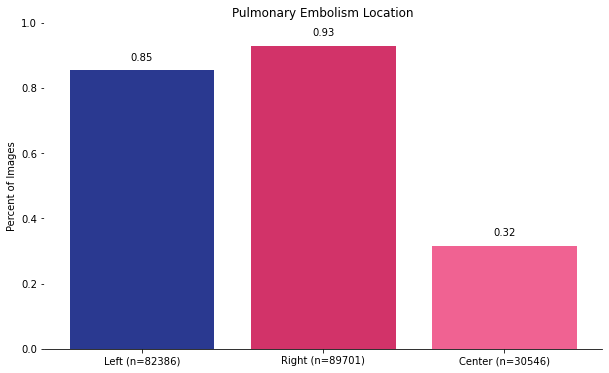

In [127]:
location_df = df[df.pe_present_on_image==1][['leftsided_pe','rightsided_pe','central_pe']]
y = location_df.mean()

feature_names = ['Left', 'Right', 'Center']
x = []
for i in range(len(feature_names)):
    x.append('%s (n=%s)'%(feature_names[i], str(location_df.sum()[i])))

make_bar(x,y,
        title='Pulmonary Embolism Location',
        y_label='Percent of Images')
    


### RV/LV Ratio Greater Than 1 in Most PE Patients
Among participants who tested positive for PE, **54 percent** had an RV/LV ratio greater than one. This would imply that their right ventricle is larger in size than their left ventricle - a phenomenon indicative of higher risk of morbidity.

<ipython-input-128-b3260509ee51>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rvlv_df = df[df.negative_exam_for_pe==0].groupby('StudyInstanceUID')['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1'].median()


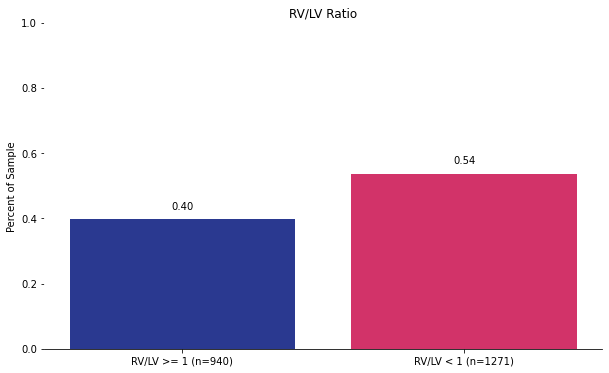

In [128]:
rvlv_df = df[df.negative_exam_for_pe==0].groupby('StudyInstanceUID')['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1'].median()
y = rvlv_df.mean()

feature_names = ['RV/LV >= 1', 'RV/LV < 1']
x = []
for i in range(len(feature_names)):
    x.append('%s (n=%s)'%(feature_names[i], str(rvlv_df.sum()[i])))

make_bar(x,y,
        title='RV/LV Ratio',
        y_label='Percent of Sample')